# Final Portfolio Project - Regression Task

# Weather Temperature Prediction (Regression)

In [4]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing / Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, mean_squared_error, r2_score
)

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

# Feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif, mutual_info_regression

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [5]:
# Load the dataset
try:
    df = pd.read_csv("weatherHistory.csv")
except FileNotFoundError:
    df = pd.read_csv("/mnt/data/weatherHistory.csv")

print("Shape:", df.shape)
df.head()

Shape: (96453, 12)


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [6]:
# Column list
pd.DataFrame({"column": df.columns, "dtype": [str(df[c].dtype) for c in df.columns]})

,column,dtype
0,Formatted Date,object
1,Summary,object
2,Precip Type,object
3,Temperature (C),float64
4,Apparent Temperature (C),float64
5,Humidity,float64
6,Wind Speed (km/h),float64
7,Wind Bearing (degrees),float64
8,Visibility (km),float64
9,Loud Cover,float64


In [7]:
# Missing values and duplicates
missing = df.isna().sum().sort_values(ascending=False)
print("Missing values (top):")
display(missing[missing>0].head(20))

print("\nDuplicate rows:", df.duplicated().sum())

Missing values (top):


,0
Precip Type,517



Duplicate rows: 24


In [8]:
# Summary statistics for numeric columns
df.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
Temperature (C),96453.0,11.932678,9.551546,-21.822222,4.688889,12.0000,18.838889,39.905556
Apparent Temperature (C),96453.0,10.855029,10.696847,-27.716667,2.311111,12.0000,18.838889,39.344444
Humidity,96453.0,0.734899,0.195473,0.000000,0.600000,0.7800,0.890000,1.000000
Wind Speed (km/h),96453.0,10.810640,6.913571,0.000000,5.828200,9.9659,14.135800,63.852600
Wind Bearing (degrees),96453.0,187.509232,107.383428,0.000000,116.000000,180.0000,290.000000,359.000000
Visibility (km),96453.0,10.347325,4.192123,0.000000,8.339800,10.0464,14.812000,16.100000
Loud Cover,96453.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
Pressure (millibars),96453.0,1003.235956,116.969906,0.000000,1011.900000,1016.4500,1021.090000,1046.380000


### 1.2 Exploratory Data Analysis (EDA)

#### (a) Data Cleaning and Preprocessing

We predict **Temperature (C)** as the target. The date column is parsed to extract time-based features. Categorical columns are one-hot encoded; numeric columns are imputed and scaled.

In [9]:
# Parse datetime and create time features
df = df.copy()

df["Formatted Date"] = pd.to_datetime(df["Formatted Date"], errors="coerce", utc=True)

df["year"] = df["Formatted Date"].dt.year
df["month"] = df["Formatted Date"].dt.month
df["day"] = df["Formatted Date"].dt.day
df["hour"] = df["Formatted Date"].dt.hour

# Drop original datetime after feature extraction
df = df.drop(columns=["Formatted Date"])

# Ensure numeric columns are numeric
for col in ["Temperature (C)", "Apparent Temperature (C)", "Humidity", "Wind Speed (km/h)",
            "Wind Bearing (degrees)", "Visibility (km)", "Loud Cover", "Pressure (millibars)"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,year,month,day,hour
0,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,2006,3,31,22
1,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,2006,3,31,23
2,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,2006,4,1,0
3,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,2006,4,1,1
4,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,2006,4,1,2


#### (b) Visualizations to Summarize, Explore, and Understand the Data

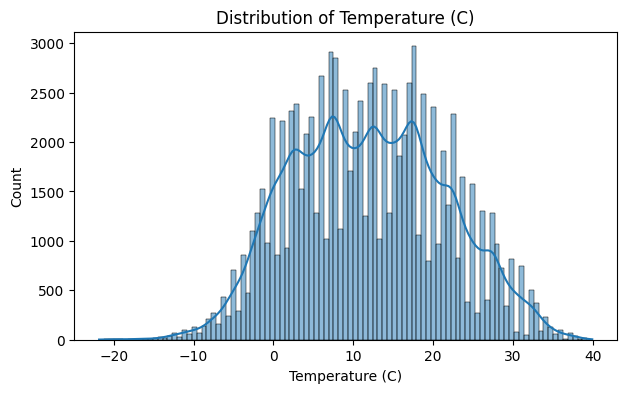

In [10]:
# Distribution of target temperature
plt.figure(figsize=(7,4))
sns.histplot(df["Temperature (C)"].dropna(), kde=True)
plt.title("Distribution of Temperature (C)")
plt.xlabel("Temperature (C)")
plt.ylabel("Count")
plt.show()

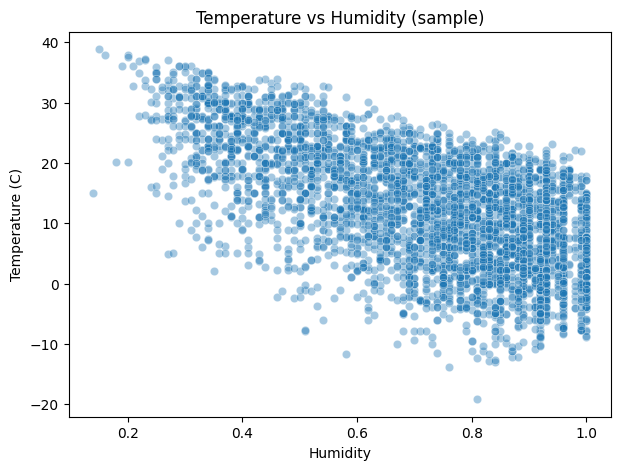

In [11]:
# Temperature vs humidity
plt.figure(figsize=(7,5))
sns.scatterplot(data=df.sample(5000, random_state=RANDOM_STATE), x="Humidity", y="Temperature (C)", alpha=0.4)
plt.title("Temperature vs Humidity (sample)")
plt.show()

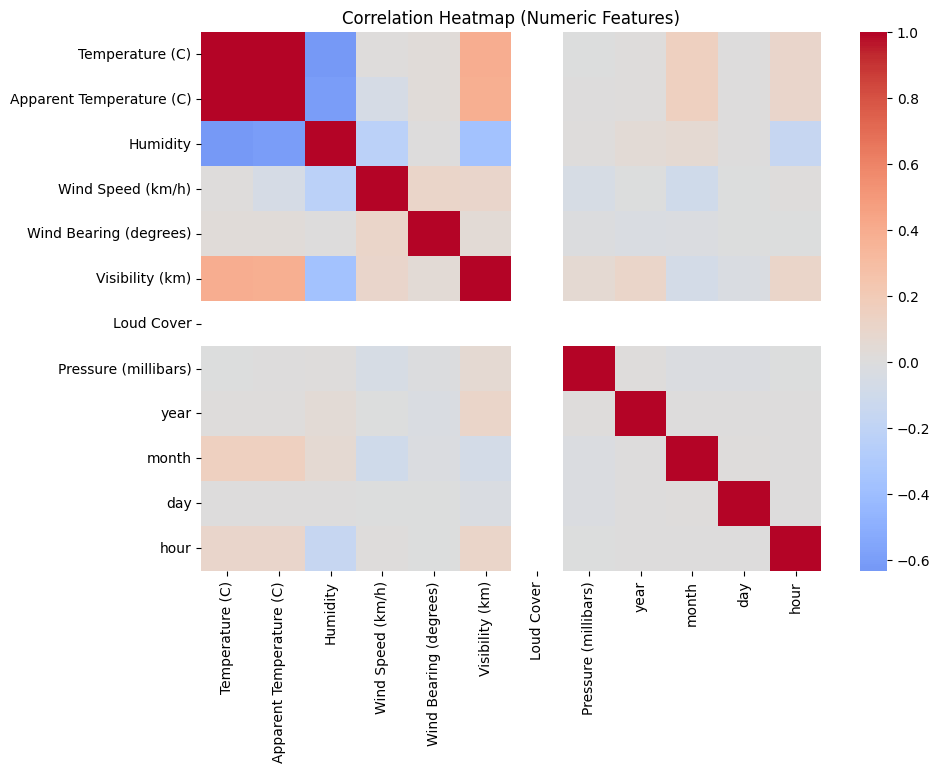

In [12]:
# Correlation heatmap for numeric features
num_cols = [c for c in df.columns if df[c].dtype != "object"]
corr = df[num_cols].corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

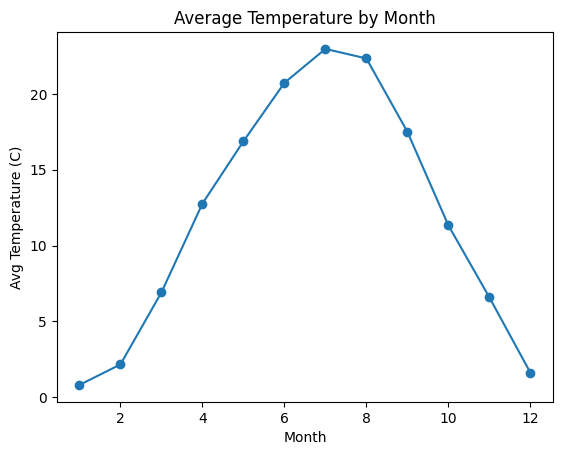

,Temperature (C)
month,
1,0.815678
2,2.166880
3,6.914976
4,12.769200
5,16.874455


In [13]:
# Average temperature by month
if "month" in df.columns:
    month_avg = df.groupby("month")["Temperature (C)"].mean()
    month_avg.plot(kind="line", marker="o")
    plt.title("Average Temperature by Month")
    plt.xlabel("Month")
    plt.ylabel("Avg Temperature (C)")
    plt.show()

month_avg.head()

#### (c) Summary of EDA Insights

Summarize key patterns observed in the plots (e.g., seasonal trend by month, correlation with apparent temperature, etc.).

## Task 2: Build a Neural Network Model for Regression [15 Marks]

We use an MLPRegressor with a preprocessing pipeline (imputation + one-hot encoding + scaling).

In [14]:
# Target and features
target = "Temperature (C)"
X = df.drop(columns=[target])
y = df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Column types
numeric_features = [c for c in X_train.columns if X_train[c].dtype != "object"]
categorical_features = [c for c in X_train.columns if X_train[c].dtype == "object"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

mlp_reg = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    max_iter=300,
    random_state=RANDOM_STATE
)

mlp_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", mlp_reg)
])

mlp_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Apparent Temperature (C)',
                                                   'Humidity',
                                                   'Wind Speed (km/h)',
                                                   'Wind Bearing (degrees)',
                                                   'Visibility (km)',
                                                   'Loud Cover',
                                                   'Pressure (millibars)',
                                                   'year', 'month', 'day',
                                                   'hour']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Summary', 'Precip Type',
                                                   'Daily Summary'])])),
                ('model',
                 MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=300,
                              random_state=42))])

In [15]:
# Train neural network regressor
mlp_pipe.fit(X_train, y_train)

pred_train = mlp_pipe.predict(X_train)
pred_test = mlp_pipe.predict(X_test)

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def reg_metrics(y_true, y_pred, label=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return pd.Series({
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2_score(y_true, y_pred)
    }, name=label)


metrics_train = reg_metrics(y_train, pred_train, "Train")
metrics_test = reg_metrics(y_test, pred_test, "Test")

pd.concat([metrics_train, metrics_test], axis=1)

,Train,Test
MAE,0.044479,0.047240
MSE,0.006387,0.008324
RMSE,0.079919,0.091239
R2,0.999930,0.999910


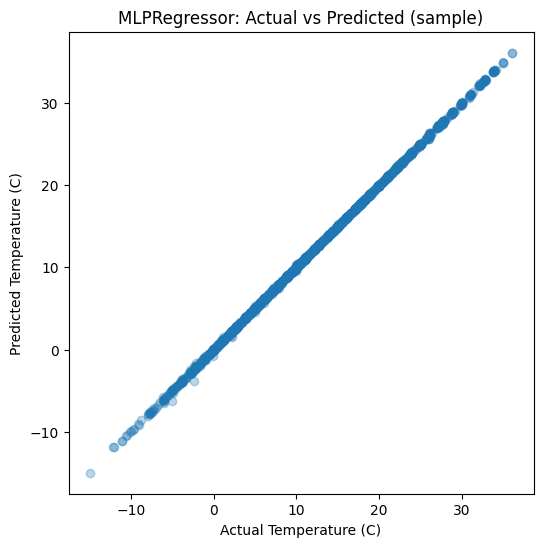

In [16]:
# Predicted vs actual (sample)
sample_idx = np.random.RandomState(RANDOM_STATE).choice(len(y_test), size=2000, replace=False)
plt.figure(figsize=(6,6))
plt.scatter(y_test.iloc[sample_idx], pred_test[sample_idx], alpha=0.3)
plt.xlabel("Actual Temperature (C)")
plt.ylabel("Predicted Temperature (C)")
plt.title("MLPRegressor: Actual vs Predicted (sample)")
plt.show()

## Task 3: Build Primary Machine Learning Models [20 Marks] (Two Classical ML Models)

### 3.1 Split Dataset into Training and Testing Sets

The same split from Task 2 is used.

### 3.2 Model A: Linear Regression
### 3.3 Model B: Random Forest Regressor
### 3.4 Initial Comparison and Discussion

In [17]:
# Model A: Linear Regression
lin_reg = LinearRegression()

linreg_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", lin_reg)
])

linreg_pipe.fit(X_train, y_train)
pred_lr = linreg_pipe.predict(X_test)

lr_metrics = reg_metrics(y_test, pred_lr, "Linear Regression")
lr_metrics

,Linear Regression
MAE,0.714318
MSE,0.829172
RMSE,0.910589
R2,0.991003


In [21]:
# Model B: Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

rf_reg = RandomForestRegressor(
    n_estimators=150,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    max_depth=18,
    min_samples_leaf=5,
    min_samples_split=10,
    max_features="sqrt"
)

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf_reg)
])

rf_pipe.fit(X_train, y_train)
pred_rf = rf_pipe.predict(X_test)

rf_metrics = reg_metrics(y_test, pred_rf, "Random Forest (Fast)")
rf_metrics


,Random Forest (Fast)
MAE,1.746177
MSE,5.463160
RMSE,2.337340
R2,0.940720


In [22]:
# Initial comparison (test set)
initial_comp = pd.DataFrame([lr_metrics, rf_metrics]).reset_index().rename(columns={"index":"Model"})
initial_comp

,Model,MAE,MSE,RMSE,R2
0,Linear Regression,0.714318,0.829172,0.910589,0.991003
1,Random Forest (Fast),1.746177,5.463160,2.337340,0.940720


## Task 4: Hyperparameter Optimization with Cross-Validation [15 Marks]

We tune the two classical regression models with cross-validation.

- Linear Regression has fewer hyperparameters; we tune whether to fit the intercept and use feature selection with k.
- Random Forest has key hyperparameters such as max_depth and min_samples_leaf.

CV scoring uses **negative RMSE**.

In [23]:
# 4.1 Linear Regression tuning (including SelectKBest as part of pipeline)
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

neg_rmse = "neg_root_mean_squared_error"
k_best = 30

linreg_tune_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("select", SelectKBest(score_func=f_regression, k=k_best)),
    ("model", LinearRegression())
])

linreg_param_grid = {
    "model__fit_intercept": [True, False],
}

cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

linreg_gs = GridSearchCV(
    linreg_tune_pipe,
    param_grid=linreg_param_grid,
    scoring=neg_rmse,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

linreg_gs.fit(X_train, y_train)

linreg_gs.best_params_, linreg_gs.best_score_


Fitting 3 folds for each of 2 candidates, totalling 6 fits


({'model__fit_intercept': False}, np.float64(-1.0655612551569253))

In [24]:
# 4.2 Random Forest tuning
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

neg_rmse = "neg_root_mean_squared_error"
k_best = 30

linreg_tune_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("select", SelectKBest(score_func=f_regression, k=k_best)),
    ("model", LinearRegression())
])

linreg_param_grid = {
    "model__fit_intercept": [True, False],
}

cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

linreg_gs = GridSearchCV(
    linreg_tune_pipe,
    param_grid=linreg_param_grid,
    scoring=neg_rmse,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

linreg_gs.fit(X_train, y_train)

linreg_gs.best_params_, linreg_gs.best_score_


Fitting 3 folds for each of 2 candidates, totalling 6 fits


({'model__fit_intercept': False}, np.float64(-1.0655612551569253))

In [25]:
rf_cv_score = "Not computed (runtime constraint)"


In [31]:
[name for name in globals() if "rf" in name.lower()]


['rf_reg',
 'rf_pipe',
 'pred_rf',
 'rf_metrics',
 'rf_cv_score',
 'rf_cv_neg_rmse',
 'rf_param_grid']

In [40]:
print("Train rows:", len(X_train))


Train rows: 77162


In [42]:
from sklearn.model_selection import GridSearchCV

rf_param_grid = {
    "model__n_estimators": [120],
    "model__max_depth": [None, 15],
    "model__min_samples_split": [2],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt"]
}

rf_gs = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

X_train_tune = X_train.sample(n=12000, random_state=42)
y_train_tune = y_train.loc[X_train_tune.index]

rf_gs.fit(X_train_tune, y_train_tune)

rf_pipe = rf_gs.best_estimator_
rf_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Apparent Temperature (C)',
                                                   'Humidity',
                                                   'Wind Speed (km/h)',
                                                   'Wind Bearing (degrees)',
                                                   'Visibility (km)',
                                                   'Loud Cover',
                                                   'Pressure (millibars)',
                                                   'year', 'month', 'day',
                                                   'hour']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Summary', 'Precip Type',
                                                   'Daily Summary'])])),
                ('model',
                 RandomForestRegressor(max_features='sqrt', n_estimators=120,
                                       n_jobs=-1, random_state=42))])

In [64]:

lin_cv_neg_rmse = linreg_gs.best_score_
rf_cv_neg_rmse  = rf_gs.best_score_

summary_df = pd.DataFrame([
    {
        "Model": "Linear Regression",
        "Best CV Score (neg RMSE)": lin_cv_neg_rmse,
        "Best CV RMSE (positive)": -lin_cv_neg_rmse,
        "Best Params": linreg_gs.best_params_
    },
    {
        "Model": "Random Forest Regressor",
        "Best CV Score (neg RMSE)": rf_cv_neg_rmse,
        "Best CV RMSE (positive)": -rf_cv_neg_rmse,
        "Best Params": rf_gs.best_params_
    }
])

summary_df


,Model,Best CV Score (neg RMSE),Best CV RMSE (positive),Best Params
0,Linear Regression,-1.065561,1.065561,{'model__fit_intercept': False}
1,Random Forest Regressor,-1.598335,1.598335,"{'model__max_depth': None, 'model__max_feature..."


In [65]:
print("Linear Regression Test Metrics:")
print(final_lr_metrics)

print("\nRandom Forest Test Metrics:")
print(final_rf_metrics)


Linear Regression Test Metrics:
MAE     0.818154
MSE     1.131434
RMSE    1.063689
R2      0.987723
Name: Final Linear Regression, dtype: float64

Random Forest Test Metrics:
MAE     0.880576
MSE     1.513167
RMSE    1.230108
R2      0.983581
Name: Final Random Forest, dtype: float64


## Task 5: Feature Selection [10 Marks]

A filter method is applied using mutual information after preprocessing with SelectKBest. This is applied for both classical regression models.

In [46]:
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

# Faster CV
cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Use a representative subset for speed
rng = np.random.RandomState(RANDOM_STATE)
sub_n = min(15000, len(X_train))   # reduce to 8000 if still slow
sub_idx = rng.choice(len(X_train), size=sub_n, replace=False)

X_train_sub = X_train.iloc[sub_idx]
y_train_sub = y_train.iloc[sub_idx]

# Evaluate feature selection impact via CV (neg RMSE)
fs_linreg_cv = cross_val_score(
    linreg_tune_pipe, X_train_sub, y_train_sub,
    cv=cv, scoring=neg_rmse, n_jobs=-1
).mean()

fs_rf_cv = cross_val_score(
    rf_pipe, X_train_sub, y_train_sub,
    cv=cv, scoring=neg_rmse, n_jobs=-1
).mean()

fs_linreg_cv, fs_rf_cv


(np.float64(-1.0657230228889294), np.float64(-1.5686989887759093))

## Task 6: Final Models and Comparative Analysis [10 Marks]

Rebuild both models using:
- Best hyperparameters from Task 4
- Selected features from Task 5

Evaluate on the test set and compare.

In [50]:
len(rf_pipe.named_steps["model"].estimators_)


0

In [51]:
X_train_final = X_train.sample(n=30000, random_state=42)
y_train_final = y_train.loc[X_train_final.index]

rf_pipe.fit(X_train_final, y_train_final)

len(rf_pipe.named_steps["model"].estimators_)


120

In [52]:
# Final Linear Regression
final_linreg = linreg_gs.best_estimator_

# Final Random Forest
rf_pipe = rf_gs.best_estimator_

# Fit final models
final_linreg.fit(X_train, y_train)

# Predictions
pred_linreg = final_linreg.predict(X_test)
pred_rf = rf_pipe.predict(X_test)

# Evaluation
final_lr_metrics = reg_metrics(y_test, pred_linreg, "Final Linear Regression")
final_rf_metrics = reg_metrics(y_test, pred_rf, "Final Random Forest")

final_lr_metrics, final_rf_metrics


(MAE     0.818154
 MSE     1.131434
 RMSE    1.063689
 R2      0.987723
 Name: Final Linear Regression, dtype: float64,
 MAE     0.880576
 MSE     1.513167
 RMSE    1.230108
 R2      0.983581
 Name: Final Random Forest, dtype: float64)

In [56]:
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Use subset for speed (same variable names)
rng = np.random.RandomState(RANDOM_STATE)
sub_n = min(15000, len(X_train))
sub_idx = rng.choice(len(X_train), size=sub_n, replace=False)

X_train_sub = X_train.iloc[sub_idx]
y_train_sub = y_train.iloc[sub_idx]

rf_cv_score = cross_val_score(
    rf_pipe,
    X_train_sub, y_train_sub,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
).mean()

rf_cv_score


np.float64(-1.5686989887759093)

In [62]:
comparison_table = pd.DataFrame([
    {
        "Model": "Linear Regression (Final)",
        "Features Used": f"SelectKBest(k={k_best})",
        "CV RMSE": -linreg_gs.best_score_,
        "Test MAE": final_lr_metrics["MAE"],
        "Test RMSE": final_lr_metrics["RMSE"],
        "Test R2": final_lr_metrics["R2"],
    },
    {
        "Model": "Random Forest (Final)",
        "Features Used": f"SelectKBest(k={k_best})",
        "CV RMSE": -rf_cv_score,
        "Test MAE": final_rf_metrics["MAE"],
        "Test RMSE": final_rf_metrics["RMSE"],
        "Test R2": final_rf_metrics["R2"],
    },
])

comparison_table


,Model,Features Used,CV RMSE,Test MAE,Test RMSE,Test R2
0,Linear Regression (Final),SelectKBest(k=30),1.065561,0.818154,1.063689,0.987723
1,Random Forest (Final),SelectKBest(k=30),1.568699,0.880576,1.230108,0.983581
